### Pilot Project

#### Data Source https://www.kaggle.com/spscientist/students-performance-in-exams

In [12]:
import pandas as pd
import dill
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import f1_score
#working with text
from sklearn.feature_extraction.text import TfidfVectorizer
#normalizing data
from sklearn.preprocessing import StandardScaler
#pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import precision_score,recall_score
#imputer
from sklearn.impute import SimpleImputer
import sklearn.datasets
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *

In [13]:
def ValuCounts_Entire_DF():

    my_cols = {i:[] for i in list(df.columns)}

    for i in df.columns:
        x = df[i].value_counts(dropna= False)
        my_cols[i] = x

        print("Column name is:",i,"and it's value is:",'\n',x)
        print()

        #return my_cols 
    
def check_null_nan():
    return pd.DataFrame([df.isna().sum(), df.isnull().sum()], index={'na', 'null'})

Загрузим данные

In [14]:
df = pd.read_csv("./StudentsPerformance.csv.xls")
df.head(3)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93


## Exploratory analysis

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


No missing data but column spaces will cause an error

In [16]:
# No major outliers detected
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
math score,1000.0,66.089,15.163080,0.0,57.00,66.0,77.0,100.0
reading score,1000.0,69.169,14.600192,17.0,59.00,70.0,79.0,100.0
writing score,1000.0,68.054,15.195657,10.0,57.75,69.0,79.0,100.0


No major outliers detected

In [17]:
# no nulls/nans detected
check_null_nan()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
null,0,0,0,0,0,0,0,0
na,0,0,0,0,0,0,0,0


In [18]:
#ValuCounts_Entire_DF()
#Let's look at the value counts for each.
# non numerical values
for col in df.select_dtypes(include='object').columns:
  print(f'---Value counts for {col}---\n {df[col].value_counts()}. \n\n')

---Value counts for gender---
 female    518
male      482
Name: gender, dtype: int64. 


---Value counts for race/ethnicity---
 group C    319
group D    262
group B    190
group E    140
group A     89
Name: race/ethnicity, dtype: int64. 


---Value counts for parental level of education---
 some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: parental level of education, dtype: int64. 


---Value counts for lunch---
 standard        645
free/reduced    355
Name: lunch, dtype: int64. 


---Value counts for test preparation course---
 none         642
completed    358
Name: test preparation course, dtype: int64. 




In [19]:
# Check for duplicates
df.duplicated(keep='first').value_counts()

False    1000
dtype: int64

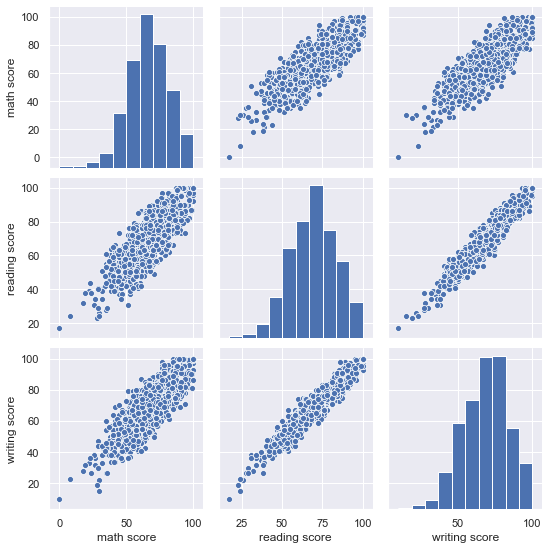

In [20]:
#check distribution & trend of test scores. Anything that stands out?
sns.pairplot(df)
plt.show()

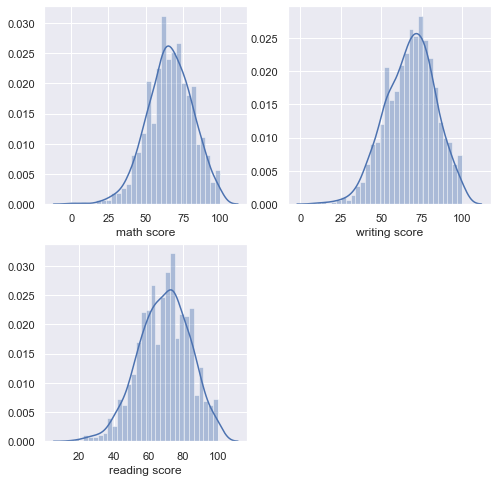

In [21]:
sns.set(rc={"figure.figsize": (8, 8)}); 

subplot(2,2,1)
ax =sns.distplot(df['math score'], bins=30)

subplot(2,2,2)
ax = sns.distplot(df['writing score'], bins=30)

subplot(2,2,3)
ax = sns.distplot(df['reading score'], bins=30)

Scores have a normal distribution

In [22]:
#For labling on bar chart
def autolabel(viz):
  for p in viz.patches:
    viz.annotate(format(p.get_height(), '.2f'), 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', 
                 va = 'center', 
                 xytext = (0, 10), 
                 textcoords = 'offset points')

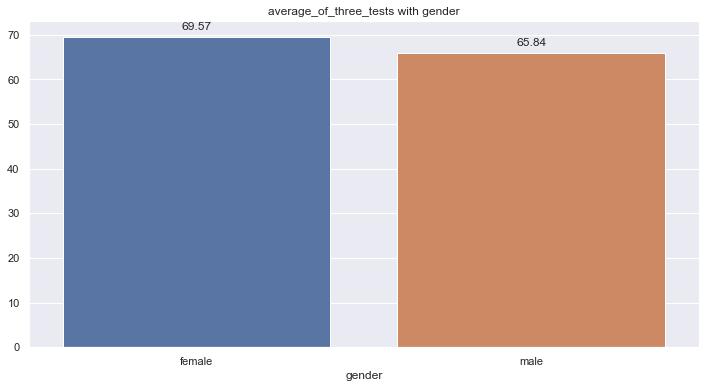

In [23]:
#gender
scores_ = (df['writing score']+df['reading score']+df['math score'])/3

fig = plt.figure(figsize=(12, 6))
viz = sns.barplot('gender', scores_, data=df, ci = None)
plt.title('average_of_three_tests with gender')
autolabel(viz)
plt.show()

Females do better then males on a slight level

### Feature engineering

In [24]:
df['gender'] = df['gender'].map({'female': 1, 'male': 0})

#### To avoid mistake like this one, replace '/' and ' '  with _

"None of [Index(['math_score'], dtype='object')] are in the [columns]"
  


In [25]:
#column names
print(f'Column names are: {df.columns}')

Column names are: Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')


In [26]:
#replace ' ' and '/' with '_'
df.columns = df.columns.str.replace(' ', '_').str.replace('/', '_')
df.columns

Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'math_score', 'reading_score',
       'writing_score'],
      dtype='object')

In [27]:
#another way to do it

#df.rename(columns={'race/ethnicity': 'race_ethnicity', 
 #                  'parental level of education': 'parental_level_of_education',
  #                 'test preparation course': 'test_preparation_course',
   #                'math score': 'math_score',
    #               'reading score': 'reading_score',
     #              'writing score': 'writing_score'
      #            }, inplace=True)

In [28]:
df.head(3)

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,1,group B,bachelor's degree,standard,none,72,72,74
1,1,group C,some college,standard,completed,69,90,88
2,1,group B,master's degree,standard,none,90,95,93


Train/Test Split, results are saved to the disk as csv files

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('gender', 1),  
                                                    df['gender'], test_size=0.33, random_state=42)

# no need to get dummies because we are using ohe encoder
#X = pd.get_dummies(df.drop('gender', axis=1))
#y = df['gender']

#save test
X_test.to_csv("X_test.csv", index=None)
y_test.to_csv("y_test.csv", index=None)
#save train
X_train.to_csv("X_train.csv", index=None)
y_train.to_csv("y_train.csv", index=None)

In [30]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

For categorical values such as race/ethnicity, parental level of education, lunch, test preparation course
we will use OHEncoder

For continous values such as math score, reading score, writing score we will use a standard scaler

Preprocessing pipeline steps

In [31]:
continuos_cols = ['math_score', 'reading_score', 'writing_score']
cat_cols = ['race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course']

continuos_transformers = []
cat_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))


Merge transformers with the FeatureUnion function

In [32]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-0.24218231, -0.40097854, -0.10836734, ...,  1.        ,
         0.        ,  1.        ],
       [-0.04103089, -0.68310573, -0.7881999 , ...,  1.        ,
         0.        ,  1.        ],
       [ 0.49537291,  1.43284823,  1.31928104, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.91268706, -0.54204214, -1.06013293, ...,  1.        ,
         0.        ,  1.        ],
       [-1.11383848, -1.52948732, -1.06013293, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.23292813,  1.50338003,  1.3872643 , ...,  1.        ,
         0.        ,  1.        ]])

Run the LogisticRegression algorithm

In [33]:
%%time

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

pipeline.fit(X_train, y_train)

Wall time: 100 ms


Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('math_score',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  NumberSelector(key='math_score')),
                                                                 ('standard',
                                                                  StandardScaler(copy=True,
                                                                                 with_mean=True,
                                                                                 with_std=True))],
                                                          verbose=False)),
                                                ('reading_score',
                                                 Pipeline(memory=None,
               

Self explanotary

In [34]:
pipeline.steps

[('features',
  FeatureUnion(n_jobs=None,
               transformer_list=[('math_score',
                                  Pipeline(memory=None,
                                           steps=[('selector',
                                                   NumberSelector(key='math_score')),
                                                  ('standard',
                                                   StandardScaler(copy=True,
                                                                  with_mean=True,
                                                                  with_std=True))],
                                           verbose=False)),
                                 ('reading_score',
                                  Pipeline(memory=None,
                                           steps=[('selector',
                                                   NumberSelector(key='reading_score')),
                                                  ('standard',
                 

Save the LogisticRegression's model (Pipeline) as dill to the disk

In [35]:
with open("logreg_pipeline.dill", "wb") as f:
    dill.dump(pipeline, f)